In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [3]:
SEQ_LEN = 128
W, H = 50, 50

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs)

In [4]:
X, Y = list(make_dataset(64).take(1))[0]
(directions, controls), (frames, game_over) = X, Y

directions.shape, controls.shape, frames.shape, game_over.shape

W1004 22:25:07.050405 139620787255104 deprecation.py:323] From /home/izpc/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(TensorShape([Dimension(64)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(2)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(50), Dimension(50)]),
 TensorShape([Dimension(64), Dimension(128)]))

In [345]:
class Model:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None
        direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input', batch_size=bs)
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input', batch_size=bs)

        self.hidden_direction = tf.keras.layers.Dense(
            100,
            name='hidden_dir_input',
        )

        self.activation_direction = tf.keras.layers.Dense(
            100,
            name='activation_dir_input',
        )

        self.transformed_user_input = tf.keras.layers.LSTM(
            100,
            return_sequences=True,
            name='transformed_user_inpuit'
        )

        self.x1 = tf.keras.layers.LSTM(
            100,
            return_sequences=True,
            name='x',
            stateful=stateful
        )

        self.x2 = tf.keras.layers.LSTM(
            100, return_sequences=True, name='x2', stateful=stateful
        )
        self.x3 = tf.keras.layers.LSTM(
            100, return_sequences=True, name='x3', stateful=stateful
        )

        self.frames1 = tf.keras.layers.Dense(W * H)
        self.frames2 = tf.keras.layers.Reshape((-1, W, H), name='frames')

        self.game_over1 = tf.keras.layers.Dense(1)
        self.game_over2 = tf.keras.layers.Lambda(
            lambda i: tf.squeeze(i, [-1], name='game_over')
        )
        
        hd = self.hidden_direction(direction_inp)
        ad = self.activation_direction(direction_inp)
        ui = self.transformed_user_input(user_input)
        x1 = self.x1(ui, initial_state=[ad, hd])
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)

        self.net = tf.keras.Model([direction_inp, user_input], [f2, g2])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
    def copy_in_stateful_model(self):
        stateful = Model(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
            
        return stateful

    def init(self, direction):
        direction = np.array(direction).reshape((1, 1))
        self.init_dir = tf.convert_to_tensor(direction, dtype=tf.float32)
        self.first_time = True
        
    def single_step_predict(self, user_input):
        user_input = np.array(user_input).reshape((1, 1, 2))
        user_input = tf.convert_to_tensor(inp, dtype=tf.float32)
        ui = self.transformed_user_input(user_input)

        if self.first_time:
            self.first_time = False

            hd = self.hidden_direction(self.init_dir)
            ad = self.activation_direction(self.init_dir)
            x1 = self.x1(ui, initial_state=[ad, hd])
        else:
            x1 = self.x1(ui)

        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)
        
        return f2.numpy().reshape(50, 50), g2.numpy()

In [346]:
model = Model()
# model.net.summary()

In [347]:
# tf.keras.utils.plot_model(model.net, to_file='model.png')

In [348]:
def plot_at_frame(frames):
    frames, gos = model.net.predict([directions, controls])
    plt.imshow(frames[0, frame], cmap='seismic')

In [349]:
def plot_pairwise_frames(frame_nums):
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames, game_over) = X, Y
    pred_frames, _ = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

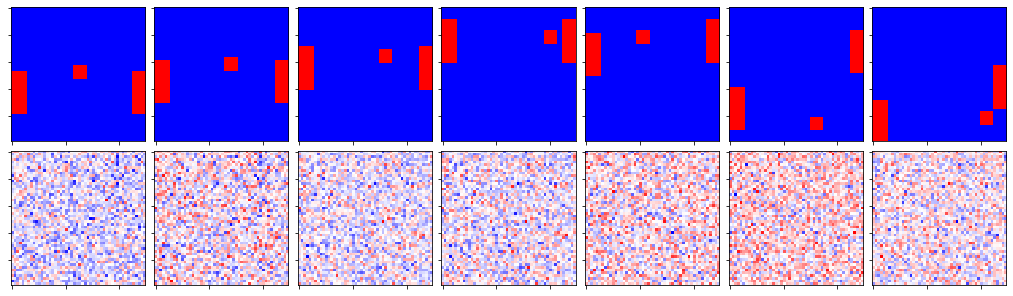

In [350]:
frame_nums = [1, 5, 10, 20, 50, 100, 120]
plot_pairwise_frames(frame_nums)

In [351]:
input_generator = make_dataset(bs=128)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=3,
    steps_per_epoch=10,
    epochs=1
)

10/10 [==============================] - 31s 3s/step - loss: 1.0533 - frames_loss: 0.6120 - lambda_20_loss: 0.4413 - frames_acc: 0.9126 - lambda_20_acc: 0.9635 - val_loss: 0.6758 - val_frames_loss: 0.4296 - val_lambda_20_loss: 0.2461 - val_frames_acc: 0.9126 - val_lambda_20_acc: 0.9711


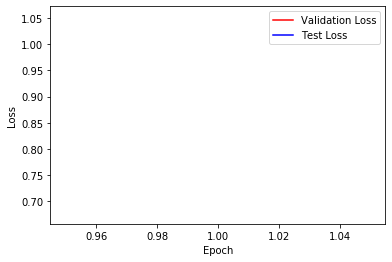

In [353]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

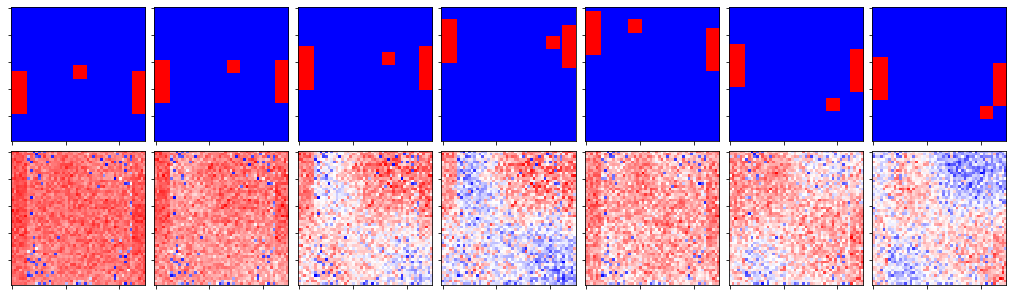

In [354]:
plot_pairwise_frames(frame_nums)

In [322]:
# model.save('LSTM3_PONG.hdf5')
# tf.saved_model.save(model, 'LSTM3_PONG_2.hdf5')

In [355]:
stateful = model.copy_in_stateful_model()

In [356]:
stateful.init(0.4)

array([[0.00967353, 0.00996812, 0.01086631, ..., 0.0061861 , 0.00872458,
        0.00864225],
       [0.00898153, 0.00739682, 0.01082732, ..., 0.00702838, 0.00557014,
        0.00781804],
       [0.00667904, 0.00862287, 0.00856144, ..., 0.00678018, 0.00684179,
        0.00580376],
       ...,
       [0.00625449, 0.00461419, 0.00674942, ..., 0.01061594, 0.00821118,
        0.00637308],
       [0.00598749, 0.00597985, 0.00607288, ..., 0.00713306, 0.00684012,
        0.00906734],
       [0.0076314 , 0.00698059, 0.00586453, ..., 0.0060984 , 0.00669393,
        0.00716259]], dtype=float32)

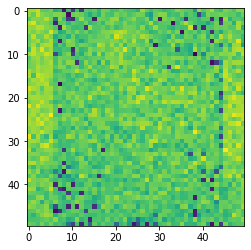

In [361]:

frame, _ = stateful.single_step_predict([1, 1])
# frame, _ = stateful.single_step_predict([1, 1])

plt.imshow(frame)
frame

In [ ]:
X, Y = list(make_dataset(1).take(1))[0]
(directions, controls), (frames, game_over) = X, Y
pred_frames, _ = model.predict([directions[:1], controls[:1, :1]])

pred_frames.shape

In [ ]:
f = model.get_layer('frames').output

In [ ]:
f.eval

In [ ]:
frames = model.get_layer('frames').output

In [ ]:
i = tf.keras.layers.Input(10)

In [221]:
t = tf.convert_to_tensor(np.random.uniform(size=(1, 2,10)), dtype=tf.float32)
t

<tf.Tensor: id=73985, shape=(1, 2, 10), dtype=float32, numpy=
array([[[0.544412  , 0.02859094, 0.38946363, 0.55995953, 0.30316696,
         0.08812146, 0.45687458, 0.5207148 , 0.5381592 , 0.4835009 ],
        [0.5124802 , 0.17753659, 0.81955904, 0.29068553, 0.92977947,
         0.44745156, 0.7999873 , 0.10802706, 0.6379675 , 0.6709232 ]]],
      dtype=float32)>

In [222]:
sl = tf.keras.layers.LSTM(10, stateful=False, dtype='float32')
sf = tf.keras.layers.LSTM(10, stateful=True)

sl(t)
sf(t)

<tf.Tensor: id=74717, shape=(1, 10), dtype=float32, numpy=
array([[ 0.0794108 , -0.19787961,  0.0086408 , -0.05633795, -0.02850436,
        -0.01810223,  0.10023549, -0.08016665,  0.08339999,  0.14080554]],
      dtype=float32)>

In [135]:
sf.set_weights(sl.get_weights())
sf.reset_states()

In [ ]:
sf.

In [140]:
sl(t)

<tf.Tensor: id=45530, shape=(1, 10), dtype=float32, numpy=
array([[ 0.21330784,  0.01145946, -0.05790524,  0.10462911,  0.0223434 ,
         0.08231489, -0.18200293,  0.11891031,  0.01784872, -0.02257713]],
      dtype=float32)>

In [142]:
sf(t)

<tf.Tensor: id=46128, shape=(1, 10), dtype=float32, numpy=
array([[ 0.35112336,  0.02083566, -0.0215419 ,  0.17646182,  0.05115838,
         0.11944667, -0.28584534,  0.16316348,  0.02189948,  0.03142062]],
      dtype=float32)>